In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('/content/weatherAUS.csv')

In [4]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [9]:
df.rename(columns = {'Temp9am':'temperature'}, inplace = True)

In [10]:
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temperature       1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [11]:
df['Date'] = pd.to_datetime(df['Date'])

In [12]:
df['Date'].head(3)

0   2008-12-01
1   2008-12-02
2   2008-12-03
Name: Date, dtype: datetime64[ns]

In [13]:
df['Temperature'].fillna(df['Temperature'].mean(), inplace=True) # we will fill the null row
df = df[['Date','Temperature' ]]
df.head()

,Date,Temperature
0,2008-12-01,16.9
1,2008-12-02,17.2
2,2008-12-03,21.0
3,2008-12-04,18.1
4,2008-12-05,17.8


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         145460 non-null  datetime64[ns]
 1   Temperature  145460 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 MB


In [18]:
df['Temperature'].describe()

count    145460.000000
mean         16.990631
std           6.449221
min          -7.200000
25%          12.300000
50%          16.800000
75%          21.500000
max          40.200000
Name: Temperature, dtype: float64

Text(0.5, 1.0, 'Temperature Average')

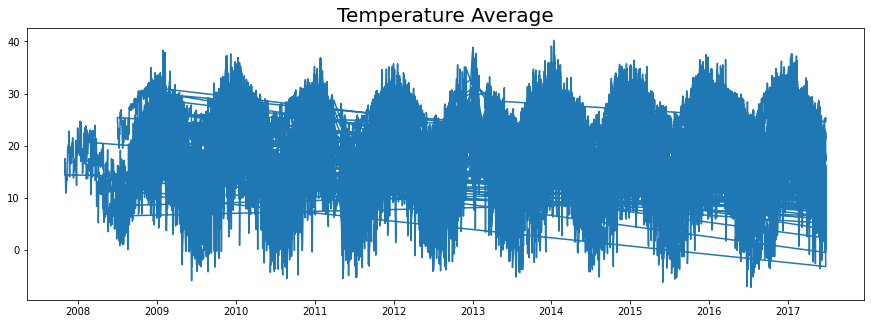

In [15]:
dates = df['Date'].values
temp = df['Temperature'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature Average',
          fontsize=20)

In [21]:
# get data values
date = df['Date'].values
temp = df['Temperature'].values

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(temp, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

116368 29092


In [25]:
data_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [26]:
max = df['Temperature'].max()
print('Max value : ' )
print(max)

Max value : 
40.2


In [27]:
min = df['Temperature'].min()
print('Min Value : ')
print(min)

Min Value : 
-7.2


In [29]:
x = (max - min) * (10 / 100)
print(x)

4.740000000000001


In [32]:
x = x.round(3)

In [33]:
x

4.74

In [34]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [35]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_train ,epochs=500, validation_data=data_test, callbacks=[callbacks])

Epoch 1/500
1164/1164 [==============================] - 318s 268ms/step - loss: 5.5900 - mae: 6.0711 - val_loss: 5.0615 - val_mae: 5.5397
Epoch 2/500
1164/1164 [==============================] - ETA: 0s - loss: 3.9803 - mae: 4.4537
MAE of the model < 10% of data scale
1164/1164 [==============================] - 296s 253ms/step - loss: 3.9803 - mae: 4.4537 - val_loss: 4.3486 - val_mae: 4.8253


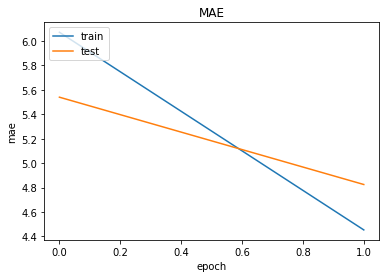

In [36]:
# plot of mae
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

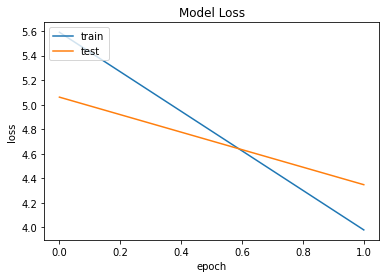

In [37]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()